In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator 
from keras.datasets import fashion_mnist 
from keras import models 
from keras import layers 
from keras import optimizers 
from keras import utils

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(f"x_train: {x_train.shape}, y_train: {y_train.shape} , x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (60000, 28, 28), y_train: (60000,) , x_test: (10000, 28, 28), y_test: (10000,)


In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784
classes = { 0:"T-shirt/top(футболка)", 
            1: "Trouser(штани)",
            2: "Pullover(світер)",
            3: "Dress(плаття)",
            4: "Coat(пальто)",
            5: "shoes(туфлі)",
            6: "shirt(сорочка)",
            7: "sneakers(кросівки)",
            8: "bag(сумка)",
            9: "Ankle boot(чоботи)"}

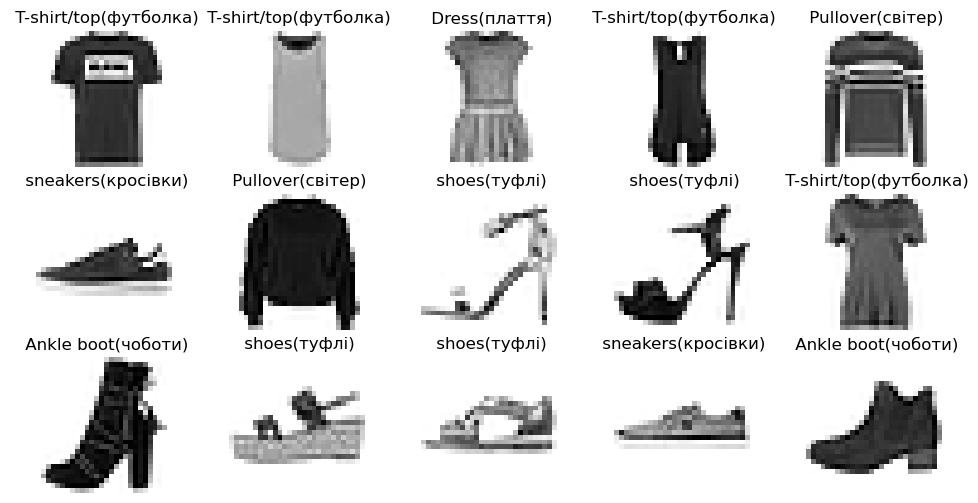

In [4]:

plt.figure(figsize=(12,6))
for i in range(1, 16):
  plt.subplot(3, 5, i-1 + 1)
  plt.imshow(x_train[i],  cmap=plt.cm.binary)
  plt.axis('off')
  plt.title(f" {classes[y_train[i]]}")


In [5]:
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1)) 

x_train = tf.keras.layers.Concatenate()([x_train, x_train, x_train])
x_test = tf.keras.layers.Concatenate()([x_test, x_test, x_test]) 

y_train = utils.to_categorical(y_train) 
y_test = utils.to_categorical(y_test)

print(f"x_train: {x_train.shape}, x_test: {x_test.shape}\ny_train: {y_train.shape}, y_test: {y_test.shape}")



x_train: (60000, 28, 28, 3), x_test: (10000, 28, 28, 3)
y_train: (60000, 10), y_test: (10000, 10)


In [6]:
x_train_res = tf.image.resize(x_train, (32, 32)) 
x_test_res = tf.image.resize(x_test, (32, 32))

print(f"x_train_res: {x_train_res.shape}, x_test_res: {x_test_res.shape}")

x_train_res: (60000, 32, 32, 3), x_test_res: (10000, 32, 32, 3)


In [7]:
from keras.preprocessing import image


train_X = np.asarray([utils.img_to_array(img) for img in x_train_res]) 
test_X = np.asarray([utils.img_to_array(img) for img in x_test_res])

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, random_state=13)

In [9]:
train_datagen = ImageDataGenerator( rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   fill_mode="nearest") 

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_datagen.fit(x_train) 
test_datagen.fit(x_val)


In [11]:
train_generator = train_datagen.flow( x_train, y_train, batch_size=200) 
test_generator = test_datagen.flow( x_val, y_val, batch_size=200)

In [12]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(120, 120, 3))
conv_base.trainable = False
original_dim = (32, 32, 3) 
target_size = (120, 120)

In [13]:
model = models.Sequential([ 
                           layers.Input(original_dim), 
                           layers.Lambda(lambda image: tf.image.resize(image, target_size)),
                           conv_base, 
                           
                           layers.Flatten(), 
                           
                           layers.Dropout(0.3), 
                           layers.Dense(256, activation="relu", kernel_initializer="he_uniform"), 
                           layers.Dense(128, activation="relu"),
                           layers.Dense(10, activation="softmax"), ])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 120, 120, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1

In [15]:
model.compile(  loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy"])

In [16]:
history = model.fit(train_generator, 
                    epochs=20, 
                    steps_per_epoch=100,
                    validation_data=test_generator, 
                    validation_steps=50, 
                    shuffle=True)

Epoch 1/20
100/100 [==============================] - 58s 434ms/step - loss: 0.5692 - accuracy: 0.1218 - val_loss: 0.3781 - val_accuracy: 0.1530
Epoch 2/20
100/100 [==============================] - 44s 439ms/step - loss: 0.3471 - accuracy: 0.1720 - val_loss: 0.2989 - val_accuracy: 0.3940
Epoch 3/20
100/100 [==============================] - 44s 442ms/step - loss: 0.3000 - accuracy: 0.3110 - val_loss: 0.2640 - val_accuracy: 0.5803
Epoch 4/20
100/100 [==============================] - 44s 444ms/step - loss: 0.2753 - accuracy: 0.4198 - val_loss: 0.2336 - val_accuracy: 0.6639
Epoch 5/20
100/100 [==============================] - 45s 446ms/step - loss: 0.2534 - accuracy: 0.5073 - val_loss: 0.2099 - val_accuracy: 0.6988
Epoch 6/20
100/100 [==============================] - 45s 446ms/step - loss: 0.2361 - accuracy: 0.5533 - val_loss: 0.1922 - val_accuracy: 0.7139
Epoch 7/20
100/100 [==============================] - 45s 447ms/step - loss: 0.2207 - accuracy: 0.5912 - val_loss: 0.1783 - val_ac

In [17]:
result_test = model.evaluate(test_X, y_test)
result_train = model.evaluate(x_train, y_train)
print("Відсоток точності тестових даних: ", round(result_test[1] * 100, 2))
print("Відсоток точності навчальних даних: ", round(result_train[1] * 100, 2))

1500/1500 [==============================] - 83s 55ms/step - loss: 0.9504 - accuracy: 0.7109
Відсоток точності тестових даних:  70.99
Відсоток точності навчальних даних:  71.09


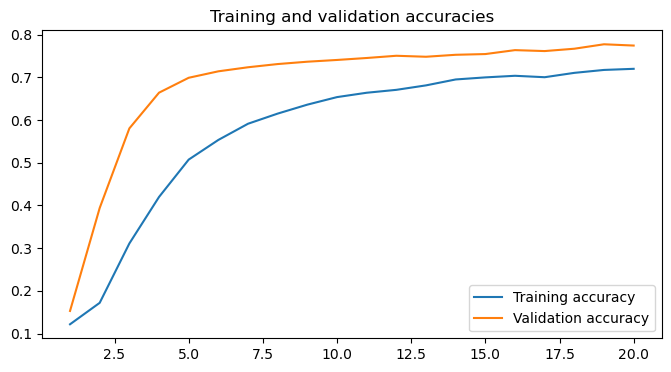

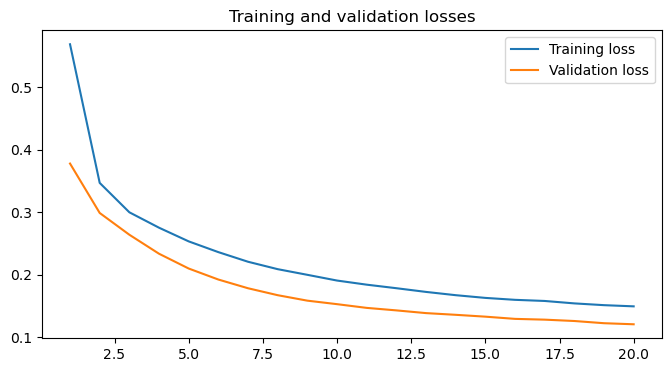

In [18]:
epochs = range(1, len(history.history["accuracy"]) + 1) 

plt.figure(figsize=(8, 4))
plt.plot(epochs, history.history["accuracy"],   label="Training accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation accuracy") 
plt.title("Training and validation accuracies") 
plt.legend() 
plt.figure(figsize=(8, 4)) 
plt.plot(epochs, history.history["loss"],  label="Training loss") 
plt.plot(epochs, history.history["val_loss"], label="Validation loss") 
plt.title("Training and validation losses") 
plt.legend()
plt.show()

In [19]:
model.save("models/vgg16_basesd_model.hdf5")

In [20]:
# model = models.load_model("models/vgg16_basesd_model.hdf5")

Донавчання

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [22]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(120, 120, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

modified_model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(1, activation="sigmoid"),
])


In [23]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["acc"]
)

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=test_generator,
    validation_steps=50
)


Epoch 1/20
100/100 [==============================] - 46s 449ms/step - loss: 0.1460 - acc: 0.7258 - val_loss: 0.1200 - val_acc: 0.7764
Epoch 2/20
100/100 [==============================] - 45s 450ms/step - loss: 0.1439 - acc: 0.7249 - val_loss: 0.1175 - val_acc: 0.7806
Epoch 3/20
100/100 [==============================] - 45s 450ms/step - loss: 0.1431 - acc: 0.7285 - val_loss: 0.1165 - val_acc: 0.7778
Epoch 4/20
100/100 [==============================] - 45s 450ms/step - loss: 0.1410 - acc: 0.7305 - val_loss: 0.1149 - val_acc: 0.7824
Epoch 5/20
100/100 [==============================] - 45s 450ms/step - loss: 0.1396 - acc: 0.7348 - val_loss: 0.1139 - val_acc: 0.7886
Epoch 6/20
100/100 [==============================] - 45s 451ms/step - loss: 0.1387 - acc: 0.7340 - val_loss: 0.1128 - val_acc: 0.7843
Epoch 7/20
100/100 [==============================] - 45s 450ms/step - loss: 0.1367 - acc: 0.7392 - val_loss: 0.1110 - val_acc: 0.7894
Epoch 8/20
100/100 [==============================] - 4

In [29]:
result_test = model.evaluate(test_X, y_test)
print("Відсоток точності тестових даних: ", round(result_test[1] * 100, 2))

313/313 [==============================] - 17s 54ms/step - loss: 1.2251 - acc: 0.7092
Відсоток точності тестових даних:  70.92


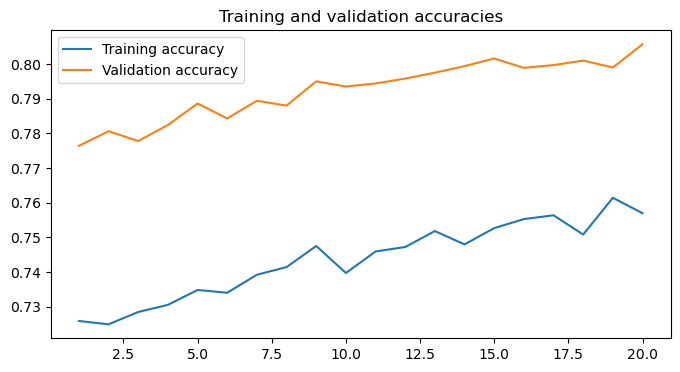

In [27]:
epochs = range(1, len(history.history["acc"]) + 1) 

plt.figure(figsize=(8, 4))
plt.plot(epochs, history.history["acc"],   label="Training accuracy")
plt.plot(epochs, history.history["val_acc"], label="Validation accuracy") 
plt.title("Training and validation accuracies") 
plt.legend()
plt.show()